#  &#x1F4D1; HW3 图像分类

# 下载数据
如果https://www.dropbox.com/s/6l2vcvxl54b0b6w/food11.zip 下载不了可以用以下途径下载数据
- [百度网盘下载(提取码：ml22)](https://pan.baidu.com/s/1ZeCvuPh1Oc2EwoVkdXlL0g)
- [Kaggle Data: ml2022spring-hw3b](https://www.kaggle.com/competitions/ml2022spring-hw3b/data)

# 加载包

In [3]:
# !pip install torchviz

In [4]:
import numpy as np
import pandas as pd
import torch
import math
import os
import random
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchviz import make_dot
# "ConcatDataset" 和"Subset" 会在半监督学习的数据用到
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset

# 用于显示进度条
from tqdm.auto import tqdm
from tqdm import tqdm
import random

# 绘制评估曲线
from torch.utils.tensorboard import SummaryWriter

# **一些重要的函数**

In [5]:
def model_plot(model_class, input_sample):
    clf = model_class()
    y = clf(input_sample) 
    clf_view = make_dot(y, params=dict(list(clf.named_parameters()) + [('x', input_sample)]))
    return clf_view

# 设置全局的随机种子
def all_seed(seed = 6666):
    """
    设置随机种子
    """
    np.random.seed(seed)
    random.seed(seed)
    # CPU
    torch.manual_seed(seed) 
    # GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed) 
    # python 全局
    os.environ['PYTHONHASHSEED'] = str(seed) 
    # cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
    print(f'Set env random_seed = {seed}')
    

def quick_observe(train_dir_root):
    """
    快速观察训练集中的9张照片
    """
    pics_path = [os.path.join(train_dir_root, i) for i in os.listdir(train_dir_root)]
    labels = [i.split('_')[0] for i in os.listdir(train_dir_root)]
    idxs = np.arange(len(labels))
    sample_idx = np.random.choice(idxs, size=9, replace=False)
    fig, axes = plt.subplots(3, 3, figsize=(20, 20))
    for idx_, i in enumerate(sample_idx):
        row = idx_ // 3
        col = idx_ % 3
        img=Image.open(pics_path[i])
        axes[row, col].imshow(img)
        c = labels[i]
        axes[row, col].set_title(f'class_{c}')

    plt.show()

# **数据准备( 数据转换、数据扩增 )**

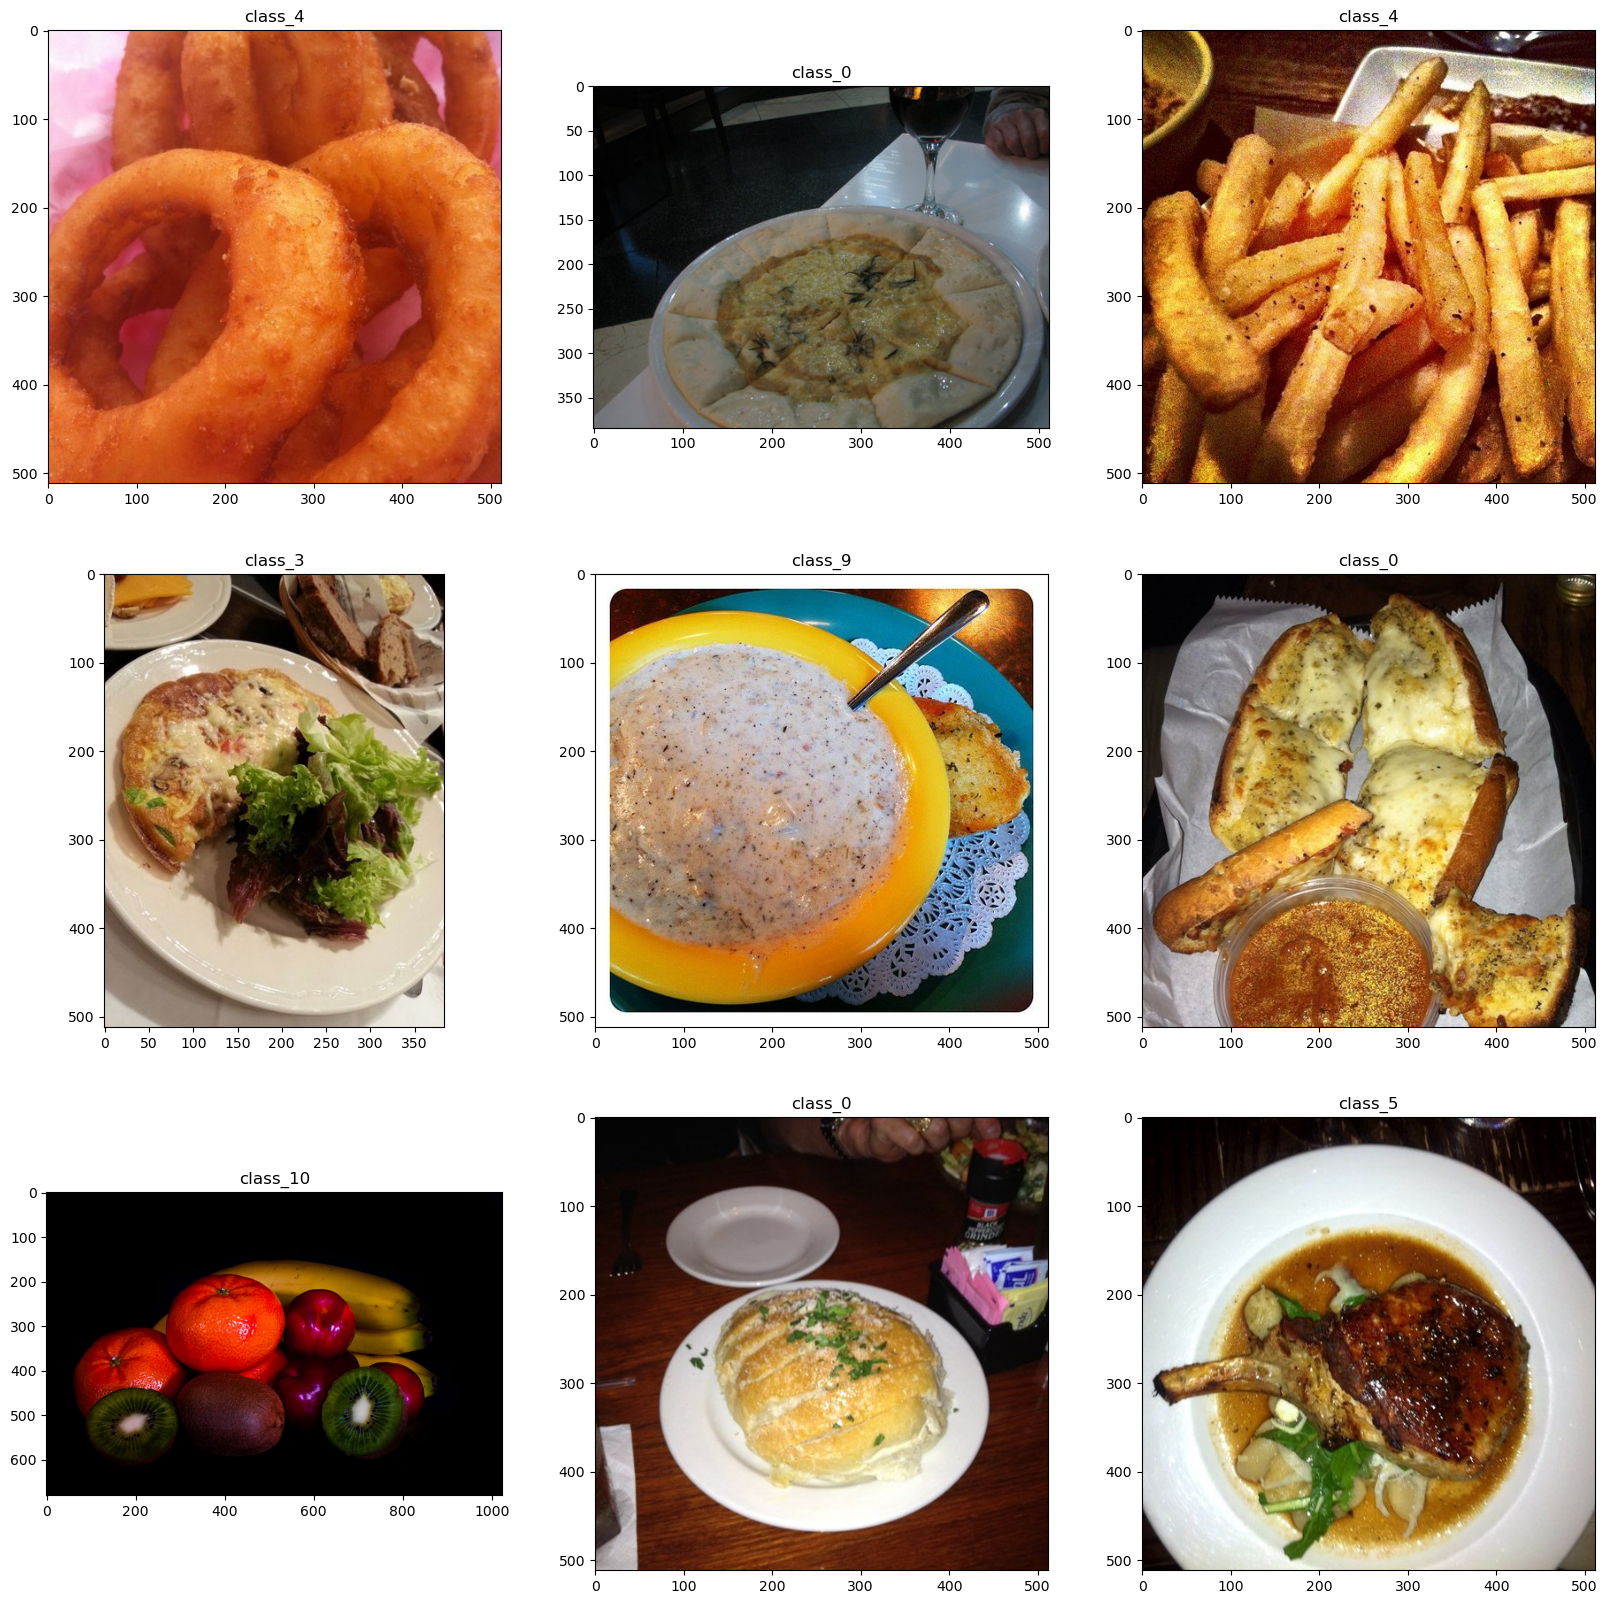

In [6]:
train_dir_root = './food11/training'
quick_observe(train_dir_root)

##  &#x2728;  **Transforms**
<font color=darkred><b>***TODO***: 尝试一些图片处理及数据扩增的方法</font></b>  
<font color=darkred><b>***TODO***: 尝试一些Ensemble方法</font></b>  
- `Torchvision` 中有很多图片处理的方法，还有很多数据扩增 (data augmentation) 的方法， 可以参考[Pytorch官网](https://pytorch.org/vision/stable/index.html)进一步的了解学习不同的数据处理方法
- [transforms官方使用示例](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py)

从上图中我们可以看出照片的大小都是不一致的，最小的图片处理也需要将图片切成一样大小的



In [7]:
# 一般情况下，我们不会在验证集和测试集上做数据扩增
# 我们只需要将图片裁剪成同样的大小并装换成Tensor就行
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# 当然，我们也可以再测试集中对数据进行扩增（对同样本的不同装换）
#  - 用训练数据的装化方法（train_tfm）去对测试集数据进行转化，产出扩增样本
#  - 对同个照片的不同样本分别进行预测
#  - 最后可以用soft vote / hard vote 等集成方法输出最后的预测
train_tfm = transforms.Compose([
    # 图片裁剪 (height = width = 128)
    transforms.Resize((128, 128)),
    # TODO:在这部分还可以增加一些图片处理的操作
    transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
    # ToTensor() 放在所有处理的最后
    transforms.ToTensor(),
])

# **数据集**
数据的标签在文件名中, 我们可以在加载的数据将文件名处理成标签

In [8]:
class FoodDataset(Dataset):

    def __init__(self,path,tfm=test_tfm,files = None):
        super(FoodDataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files
        print(f"One {path} sample",self.files[0])
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 # 测试集没有label
        return im,label

#  &#x2728; **神经网络模型**
<font color=darkred><b>***TODO***: 尝试一些现成的网络框架</font></b>  
- 参考官网中的一些模型[torchvision.models](https://pytorch.org/vision/stable/models.html)
    - AlexNet
    - ConvNeXt
    - DenseNet
    - EfficientNet
    - EfficientNetV2
    - GoogLeNet
    - Inception V3
    - MaxVit
    - MNASNet
    - MobileNet V2
    - MobileNet V3
    - RegNet
    - ResNet
    - ResNeXt
    - ShuffleNet V2
    - SqueezeNet
    - SwinTransformer
    - VGG
    - VisionTransformer
    - Wide ResNet



In [9]:
from torchvision.models import resnet50

resNet = resnet50(pretrained=False)


class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # input 維度 [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)
    

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # 如果维度不匹配，需要1x1卷积调整
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, 0),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # ✨ 残差连接
        out = nn.ReLU()(out)
        return out

class ResNetClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 7, 2, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3, 2, 1)
        )  # [64, 32, 32]
        
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 11)
        )
    
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.flatten(1)
        x = self.fc(x)
        return x


/home/liuzipeng/miniconda3/envs/jupyter_learn/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/liuzipeng/miniconda3/envs/jupyter_learn/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [10]:
x = torch.randn(1, 3, 128, 128).requires_grad_(True)
# model_plot(Classifier, x)

#   &#x2728; 训练部分

In [11]:
def trainer(train_loader, valid_loader, model, config, device, rest_net_flag=False):

    # 对于分类任务, 我们常用cross-entropy评估模型表现.
    criterion = nn.CrossEntropyLoss(ignore_index=-1)  # 交叉熵计算时，label范围为[0, n_classes-1]
    # 初始化优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay']) 
    # 模型存储位置
    save_path =  config['save_path'] if rest_net_flag else  config['resnet_save_path']

    writer = SummaryWriter()
    if not os.path.isdir('./models'):
        os.mkdir('./models')

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0
    for epoch in range(n_epochs):
        model.train()
        loss_record = []
        train_accs = []
        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_pbar:
            optimizer.zero_grad()             
            x, y = x.to(device), y.to(device)  
            pred = model(x)             
            loss = criterion(pred, y)
            loss.backward()                   
            # 稳定训练的技巧
            if config['clip_flag']:
                grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

            optimizer.step()    
            step += 1
            acc = (pred.argmax(dim=-1) == y.to(device)).float().mean()
            l_ = loss.detach().item()
            loss_record.append(l_)
            train_accs.append(acc.detach().item())
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': f'{l_:.5f}', 'acc': f'{acc:.5f}'})
        
        
        mean_train_acc = sum(train_accs) / len(train_accs)
        mean_train_loss = sum(loss_record)/len(loss_record)
        writer.add_scalar('Loss/train', mean_train_loss, step)
        writer.add_scalar('ACC/train', mean_train_acc, step)
        model.eval() # 设置模型为评估模式
        loss_record = []
        test_accs = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)
                acc = (pred.argmax(dim=-1) == y.to(device)).float().mean()

            loss_record.append(loss.item())
            test_accs.append(acc.detach().item())
            
        mean_valid_acc = sum(test_accs) / len(test_accs)
        mean_valid_loss = sum(loss_record)/len(loss_record)
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f},acc: {mean_train_acc:.4f} Valid loss: {mean_valid_loss:.4f},acc: {mean_valid_acc:.4f} ')
        writer.add_scalar('Loss/valid', mean_valid_loss, step)
        writer.add_scalar('ACC/valid', mean_valid_acc, step)
        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), save_path) # 保存最优模型
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return

# **超参设置**
`config` 包含所有训练需要的超参数（便于后续的调参），以及模型需要存储的位置

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 6233,
    'dataset_dir': "./food11",
    'n_epochs': 20,      
    'batch_size': 256, 
    'learning_rate': 0.0003,           
    'weight_decay':1e-5,
    'early_stop': 300,
    'clip_flag': True, 
    'save_path': './models/model.ckpt',
    'resnet_save_path': './models/resnet_model.ckpt'
}
print(device)
all_seed(config['seed'])

cuda
Set env random_seed = 6233


# **导入数据集**
1. FoodDataset： 用文件路径，transform方法构建数据集
2. DataLoader： 
    - 使用Pytorch中Dataloader类按照Batch将数据集加载

In [13]:
_dataset_dir = config['dataset_dir']

train_set = FoodDataset(os.path.join(_dataset_dir,"training"), tfm=train_tfm)
train_loader = DataLoader(train_set, batch_size=config['batch_size'], shuffle=True, num_workers=8, pin_memory=True)

valid_set = FoodDataset(os.path.join(_dataset_dir,"validation"), tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=config['batch_size'], shuffle=True, num_workers=8, pin_memory=True)

# 测试级保证输出顺序一致
test_set = FoodDataset(os.path.join(_dataset_dir,"test"), tfm=test_tfm)
test_loader = DataLoader(test_set, batch_size=config['batch_size'], shuffle=False, num_workers=8, pin_memory=True)

One ./food11/training sample ./food11/training/0_0.jpg
One ./food11/validation sample ./food11/validation/0_0.jpg
One ./food11/test sample ./food11/test/0001.jpg


##  &#x2728; 测试集数据扩增

In [14]:
test_set = FoodDataset(os.path.join(_dataset_dir,"test"), tfm=train_tfm)
test_loader_extra1 = DataLoader(test_set, batch_size=config['batch_size'], shuffle=False, num_workers=8, pin_memory=True)

test_set = FoodDataset(os.path.join(_dataset_dir,"test"), tfm=train_tfm)
test_loader_extra2 = DataLoader(test_set, batch_size=config['batch_size'], shuffle=False, num_workers=8, pin_memory=True)

test_set = FoodDataset(os.path.join(_dataset_dir,"test"), tfm=train_tfm)
test_loader_extra3 = DataLoader(test_set, batch_size=config['batch_size'], shuffle=False, num_workers=8, pin_memory=True)

One ./food11/test sample ./food11/test/0001.jpg
One ./food11/test sample ./food11/test/0001.jpg
One ./food11/test sample ./food11/test/0001.jpg


#  &#x1F4CC; **开始训练！**

In [15]:
# model = Classifier().to(device)
model = ResNetClassifier().to(device)
trainer(train_loader, valid_loader, model, config, device)

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [1/20]: 100%|██████████| 39/39 [00:16<00:00,  2.39it/s, loss=2.12580, acc=0.22464]


Epoch [1/20]: Train loss: 2.2811,acc: 0.2048 Valid loss: 2.9337,acc: 0.1589 
Saving model with loss 2.934...


Epoch [2/20]: 100%|██████████| 39/39 [00:16<00:00,  2.42it/s, loss=2.10952, acc=0.26812]


Epoch [2/20]: Train loss: 2.0370,acc: 0.2993 Valid loss: 1.8956,acc: 0.3524 
Saving model with loss 1.896...


Epoch [3/20]: 100%|██████████| 39/39 [00:14<00:00,  2.63it/s, loss=1.83102, acc=0.38406]


Epoch [3/20]: Train loss: 1.8796,acc: 0.3473 Valid loss: 2.1694,acc: 0.3348 


Epoch [4/20]: 100%|██████████| 39/39 [00:19<00:00,  1.99it/s, loss=1.77181, acc=0.39855]


Epoch [4/20]: Train loss: 1.7847,acc: 0.3824 Valid loss: 1.6880,acc: 0.4252 
Saving model with loss 1.688...


Epoch [5/20]: 100%|██████████| 39/39 [00:14<00:00,  2.70it/s, loss=1.71636, acc=0.36232]


Epoch [5/20]: Train loss: 1.6806,acc: 0.4176 Valid loss: 2.0928,acc: 0.3667 


Epoch [6/20]: 100%|██████████| 39/39 [00:15<00:00,  2.53it/s, loss=1.40043, acc=0.55072]


Epoch [6/20]: Train loss: 1.5962,acc: 0.4485 Valid loss: 1.6381,acc: 0.4643 
Saving model with loss 1.638...


Epoch [7/20]: 100%|██████████| 39/39 [00:16<00:00,  2.34it/s, loss=1.35278, acc=0.50725]


Epoch [7/20]: Train loss: 1.4934,acc: 0.4854 Valid loss: 1.6198,acc: 0.4799 
Saving model with loss 1.620...


Epoch [8/20]: 100%|██████████| 39/39 [00:15<00:00,  2.44it/s, loss=1.57103, acc=0.46377]


Epoch [8/20]: Train loss: 1.4255,acc: 0.5098 Valid loss: 1.4377,acc: 0.5241 
Saving model with loss 1.438...


Epoch [9/20]: 100%|██████████| 39/39 [00:14<00:00,  2.60it/s, loss=1.37830, acc=0.53623]


Epoch [9/20]: Train loss: 1.3578,acc: 0.5408 Valid loss: 1.6456,acc: 0.4598 


Epoch [10/20]: 100%|██████████| 39/39 [00:14<00:00,  2.67it/s, loss=1.19255, acc=0.59420]


Epoch [10/20]: Train loss: 1.2763,acc: 0.5624 Valid loss: 1.7036,acc: 0.4808 


Epoch [11/20]: 100%|██████████| 39/39 [00:22<00:00,  1.73it/s, loss=1.22561, acc=0.58696]


Epoch [11/20]: Train loss: 1.2233,acc: 0.5847 Valid loss: 1.9825,acc: 0.4433 


Epoch [12/20]: 100%|██████████| 39/39 [00:14<00:00,  2.71it/s, loss=1.20947, acc=0.59420]


Epoch [12/20]: Train loss: 1.1483,acc: 0.6149 Valid loss: 1.6577,acc: 0.5101 


Epoch [13/20]: 100%|██████████| 39/39 [00:20<00:00,  1.91it/s, loss=1.01274, acc=0.68841]


Epoch [13/20]: Train loss: 1.0623,acc: 0.6423 Valid loss: 1.9847,acc: 0.4554 


Epoch [14/20]: 100%|██████████| 39/39 [00:13<00:00,  2.79it/s, loss=0.97359, acc=0.65942]


Epoch [14/20]: Train loss: 1.0223,acc: 0.6578 Valid loss: 1.5187,acc: 0.5369 


Epoch [15/20]: 100%|██████████| 39/39 [00:14<00:00,  2.74it/s, loss=0.96150, acc=0.67391]


Epoch [15/20]: Train loss: 0.9588,acc: 0.6797 Valid loss: 1.6983,acc: 0.5086 


Epoch [16/20]: 100%|██████████| 39/39 [00:17<00:00,  2.27it/s, loss=0.97863, acc=0.69565]


Epoch [16/20]: Train loss: 0.9094,acc: 0.7042 Valid loss: 1.9717,acc: 0.5031 


Epoch [17/20]: 100%|██████████| 39/39 [00:14<00:00,  2.71it/s, loss=0.88382, acc=0.70290]


Epoch [17/20]: Train loss: 0.8633,acc: 0.7185 Valid loss: 1.8219,acc: 0.5003 


Epoch [18/20]: 100%|██████████| 39/39 [00:14<00:00,  2.77it/s, loss=0.77834, acc=0.76087]


Epoch [18/20]: Train loss: 0.7898,acc: 0.7363 Valid loss: 1.5830,acc: 0.5387 


Epoch [19/20]: 100%|██████████| 39/39 [00:14<00:00,  2.73it/s, loss=0.74789, acc=0.72464]


Epoch [19/20]: Train loss: 0.7553,acc: 0.7550 Valid loss: 1.7654,acc: 0.5262 


Epoch [20/20]: 100%|██████████| 39/39 [00:21<00:00,  1.80it/s, loss=0.73298, acc=0.76087]


Epoch [20/20]: Train loss: 0.6807,acc: 0.7780 Valid loss: 1.3805,acc: 0.5742 
Saving model with loss 1.380...


# **测试并生成预测结果的csv**

In [16]:
model_best = ResNetClassifier().to(device)
model_best.load_state_dict(torch.load(config['resnet_save_path']))
model_best.eval()
prediction = []
with torch.no_grad():
    for data,_ in test_loader:
        test_pred = model_best(data.to(device))
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        prediction += test_label.squeeze().tolist()


##  &#x2728; soft vote（软投票）预测
- 用扩增数据进行四次测试接预测，然后用soft_vote（软投票）的方法进行预测
![](./pic/testAug.png)

In [17]:
test_loaders = [test_loader_extra1, test_loader_extra2, test_loader_extra3, test_loader]
loader_nums = len(test_loaders)
# 存储每个dataloader预测结果，一个dataloader一个数组
loader_pred_list = []
for idx, d_loader in enumerate(test_loaders):
    # 存储一个dataloader的预测结果,  一个batch一个是数组
    pred_arr_list = [] 
    with torch.no_grad():
        tq_bar = tqdm(d_loader)
        tq_bar.set_description(f"[ DataLoader {idx+1}/{loader_nums} ]")
        for data,_ in tq_bar:
            test_pred = model_best(data.to(device))
            logit_pred = test_pred.cpu().data.numpy()
            pred_arr_list.append(logit_pred)
        # 将每个batch的预测结果合并成一个数组
        loader_pred_list.append( np.concatenate(pred_arr_list, axis=0) )


# 将预测结果合并
pred_arr = np.zeros(loader_pred_list[0].shape)
for pred_arr_t in loader_pred_list:
    pred_arr += pred_arr_t


soft_vote_prediction = np.argmax(0.5 * pred_arr / len(loader_pred_list) + 0.5 * loader_pred_list[-1], axis=1)

[ DataLoader 4/4 ]: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


In [18]:
df = pd.DataFrame()
# 保证ID为四位数（前面填充0）
df["Id"] = [str(i).zfill(4) for i in range(1, len(test_set)+1)]
df["Category"] = soft_vote_prediction
df.to_csv("submission.csv",index = False)

## Q2. 残差网络（Residual Net）

In [19]:
# 残差网络
resNet = resNet.to(device)
trainer(train_loader, valid_loader, resNet, config, device)

Epoch [1/20]: 100%|██████████| 39/39 [00:17<00:00,  2.24it/s, loss=2.25982, acc=0.13768]


Epoch [1/20]: Train loss: 2.6379,acc: 0.1564 Valid loss: 2.4730,acc: 0.1457 
Saving model with loss 2.473...


Epoch [2/20]: 100%|██████████| 39/39 [00:15<00:00,  2.53it/s, loss=2.14111, acc=0.25362]


Epoch [2/20]: Train loss: 2.2190,acc: 0.2121 Valid loss: 2.2607,acc: 0.2357 
Saving model with loss 2.261...


Epoch [3/20]: 100%|██████████| 39/39 [00:16<00:00,  2.35it/s, loss=2.03894, acc=0.23913]


Epoch [3/20]: Train loss: 2.1555,acc: 0.2356 Valid loss: 2.1236,acc: 0.2461 
Saving model with loss 2.124...


Epoch [4/20]: 100%|██████████| 39/39 [00:15<00:00,  2.48it/s, loss=2.08256, acc=0.23188]


Epoch [4/20]: Train loss: 2.1251,acc: 0.2500 Valid loss: 2.1597,acc: 0.2381 


Epoch [5/20]: 100%|██████████| 39/39 [00:21<00:00,  1.81it/s, loss=2.07679, acc=0.30435]


Epoch [5/20]: Train loss: 2.0353,acc: 0.2854 Valid loss: 2.0174,acc: 0.2837 
Saving model with loss 2.017...


Epoch [6/20]: 100%|██████████| 39/39 [00:17<00:00,  2.18it/s, loss=1.82783, acc=0.34058]


Epoch [6/20]: Train loss: 1.9773,acc: 0.3059 Valid loss: 2.2788,acc: 0.2791 


Epoch [7/20]: 100%|██████████| 39/39 [00:17<00:00,  2.29it/s, loss=1.79293, acc=0.38406]


Epoch [7/20]: Train loss: 1.8893,acc: 0.3392 Valid loss: 1.9355,acc: 0.3388 
Saving model with loss 1.936...


Epoch [8/20]: 100%|██████████| 39/39 [00:17<00:00,  2.23it/s, loss=1.85487, acc=0.37681]


Epoch [8/20]: Train loss: 1.8141,acc: 0.3716 Valid loss: 1.7570,acc: 0.3931 
Saving model with loss 1.757...


Epoch [9/20]: 100%|██████████| 39/39 [00:24<00:00,  1.62it/s, loss=1.80532, acc=0.36957]


Epoch [9/20]: Train loss: 1.7589,acc: 0.3947 Valid loss: 1.9757,acc: 0.3799 


Epoch [10/20]: 100%|██████████| 39/39 [00:17<00:00,  2.25it/s, loss=1.67470, acc=0.43478]


Epoch [10/20]: Train loss: 1.6833,acc: 0.4116 Valid loss: 1.6113,acc: 0.4354 
Saving model with loss 1.611...


Epoch [11/20]: 100%|██████████| 39/39 [00:15<00:00,  2.58it/s, loss=1.69164, acc=0.47101]


Epoch [11/20]: Train loss: 1.6233,acc: 0.4429 Valid loss: 1.7244,acc: 0.4202 


Epoch [12/20]: 100%|██████████| 39/39 [00:15<00:00,  2.50it/s, loss=1.41319, acc=0.50000]


Epoch [12/20]: Train loss: 1.5335,acc: 0.4671 Valid loss: 1.6742,acc: 0.4447 


Epoch [13/20]: 100%|██████████| 39/39 [00:15<00:00,  2.53it/s, loss=1.55913, acc=0.45652]


Epoch [13/20]: Train loss: 1.4929,acc: 0.4820 Valid loss: 1.7278,acc: 0.4252 


Epoch [14/20]: 100%|██████████| 39/39 [00:20<00:00,  1.92it/s, loss=1.41143, acc=0.49275]


Epoch [14/20]: Train loss: 1.4416,acc: 0.4998 Valid loss: 1.5940,acc: 0.4766 
Saving model with loss 1.594...


Epoch [15/20]: 100%|██████████| 39/39 [00:16<00:00,  2.33it/s, loss=1.34473, acc=0.50000]


Epoch [15/20]: Train loss: 1.3679,acc: 0.5367 Valid loss: 1.9304,acc: 0.4228 


Epoch [16/20]: 100%|██████████| 39/39 [00:14<00:00,  2.65it/s, loss=1.32013, acc=0.57246]


Epoch [16/20]: Train loss: 1.3418,acc: 0.5383 Valid loss: 1.7440,acc: 0.4422 


Epoch [17/20]: 100%|██████████| 39/39 [00:18<00:00,  2.15it/s, loss=1.38146, acc=0.57246]


Epoch [17/20]: Train loss: 1.2788,acc: 0.5614 Valid loss: 1.4404,acc: 0.5264 
Saving model with loss 1.440...


Epoch [18/20]: 100%|██████████| 39/39 [00:15<00:00,  2.53it/s, loss=1.46223, acc=0.50000]


Epoch [18/20]: Train loss: 1.2050,acc: 0.5916 Valid loss: 1.5449,acc: 0.4853 


Epoch [19/20]: 100%|██████████| 39/39 [00:15<00:00,  2.56it/s, loss=1.34409, acc=0.55072]


Epoch [19/20]: Train loss: 1.1687,acc: 0.6086 Valid loss: 1.5563,acc: 0.4874 


Epoch [20/20]: 100%|██████████| 39/39 [00:23<00:00,  1.68it/s, loss=1.21091, acc=0.60870]


Epoch [20/20]: Train loss: 1.1233,acc: 0.6179 Valid loss: 1.5756,acc: 0.5120 


In [20]:
model_best = resNet.to(device)
model_best.load_state_dict(torch.load(config['resnet_save_path']))
model_best.eval()
test_loaders = [test_loader_extra1, test_loader_extra2, test_loader_extra3, test_loader]
loader_nums = len(test_loaders)
# 存储每个dataloader预测结果，一个dataloader一个数组
loader_pred_list = []
for idx, d_loader in enumerate(test_loaders):
    # 存储一个dataloader的预测结果,  一个batch一个数组
    pred_arr_list = [] 
    with torch.no_grad():
        tq_bar = tqdm(d_loader)
        tq_bar.set_description(f"[ DataLoader {idx+1}/{loader_nums} ]")
        for data,_ in tq_bar:
            test_pred = model_best(data.to(device))
            logit_pred = test_pred.cpu().data.numpy()
            pred_arr_list.append(logit_pred)
        # 将每个batch的预测结果合并成一个数组
        loader_pred_list.append( np.concatenate(pred_arr_list, axis=0) )


# 将预测结果合并
pred_arr = np.zeros(loader_pred_list[0].shape)
for pred_arr_t in loader_pred_list:
    pred_arr += pred_arr_t


soft_vote_prediction = np.argmax(0.5 * pred_arr / len(loader_pred_list) + 0.5 * loader_pred_list[-1], axis=1)

[ DataLoader 4/4 ]: 100%|██████████| 14/14 [00:06<00:00,  2.02it/s]


In [21]:
df = pd.DataFrame()
# 保证ID为四位数（前面填充0）
df["Id"] = [str(i).zfill(4) for i in range(1, len(test_set)+1)]
df["Category"] = soft_vote_prediction
df.to_csv("submission.csv",index = False)

# 贡献者

孙成超
- Github: https://github.com/scchy
- Email: hyscc1994@foxmail.com